# Motivation

The goal of this notebook is to verify the state estimation and optimization algorithms integrated into the sofa control loop.

In [314]:
# Imports
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd
from prettytable import PrettyTable

import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from dotenv import dotenv_values 
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
import scipy.io
import pyvista as pv
import h5py
import mat73
from scipy import signal
import control
import dask.array as da
import cvxpy as cp
import opinf


config = dotenv_values(".env")
from util import *

# Read in System Matrices

In [315]:
# Setup filepaths for reading data 
filepath = config["currentDirectory"] + "data/verificationData/estimationTest2/"
# Read in system and gain matrices from .mat file
systemMats = scipy.io.loadmat(filepath + "romSystemMatricesAndGains_22dim_3train_2test.mat")
# ERA matrices
A_era = systemMats["A_era"]
B_era = systemMats["B_era"]
C_era = systemMats["C_era"]
D_era = systemMats["D_era"]
L_era = systemMats["L_era"]
# DMDc Matrices
A_dmdc = systemMats["A_dmdc"]
B_dmdc = systemMats["B_dmdc"]
C_dmdc = systemMats["C_dmdc"]
L_dmdc = systemMats["L_dmdc"]
# LOpInf Matrices
A_lopinf = systemMats["A_lopinf"]
B_lopinf = systemMats["B_lopinf"]
C_lopinf = systemMats["C_lopinf"]
D_lopinf = systemMats["D_lopinf"]
L_lopinf = systemMats["L_lopinf"]

# Read in offset vector
x0 = systemMats["x0"]

# Read input data

In [316]:
# Load in data from npy file
data = np.load(filepath + "processedData_policySeed_0.npz")

Y_fom = data["reducedCenterlineData"]
U_fom = data["inputData"]
Y0_fom = data["reducedCenterlineData"][0,:]



timesteps = Y_fom.shape[0]



In [317]:
Y_fom = Y_fom.T
U_fom = U_fom.T

# Center outputs wrt Y0
Y_fom = Y_fom - Y0_fom.reshape(-1,1)


In [318]:
U_fom.shape

(6, 500)

In [319]:
# Initialize arrays to store data

# ERA
x_hat_era = np.zeros((A_era.shape[0], timesteps)) # Closed loop era observer
y_hat_era = np.zeros((C_era.shape[0], timesteps)) # Open loop era observer

# Iterate through each timestep
for i in range(timesteps-1):
    # Update Observer State
    x_hat_era[:,i+1] = A_era @ x_hat_era[:,i] + B_era @ U_fom[:,i] + L_era @ (Y_fom[:,i] - y_hat_era[:,i])
    # Update Observer Output
    y_hat_era[:,i+1] = C_era @ x_hat_era[:,i+1] + D_era @ U_fom[:,i]

In [320]:
# Initialize arrays to store data from online observer
x_hat_era_online = np.zeros((A_era.shape[0], timesteps)) # Closed loop era observer
y_hat_era_online = np.zeros((C_era.shape[0], timesteps)) # Open loop era observer
y_groundTruth_online = np.zeros((C_era.shape[0], timesteps)) # Open loop era observer
# Read in data from online observer
for i in range(timesteps):
    onlineObs_filename = filepath + "verification_step_" + str(i) + ".hdf5"
    with h5py.File(onlineObs_filename, 'r') as f:
        x_hat_era_online[:,i] = f["x_hat"][()].squeeze()
        y_hat_era_online[:,i] = C_era @ x_hat_era_online[:,i]+ D_era @ U_fom[:,i]
        y_groundTruth_online[:,i] = f["y"][()].squeeze()

In [321]:
# Compare averaging matrices to see if theyre the same
avgMat_offline = np.load(filepath + "avgMatrix_offline_corrected.npy")
with h5py.File(onlineObs_filename, 'r') as f:
    avgMat_online= f["avgMatrix"][()]


In [322]:
# Compare sizes of matrices to see if theyre the same
print("Offline Averages Matrix")
print(avgMat_offline.shape)
print("Online Averages Matrix")
print(avgMat_online.shape)
# Find the indices of the matrices that are different
diff_idx = np.where(avgMat_offline-avgMat_online>=1e-8)
# Print the indices of the matrices that are different 
print("Indices of differences") 
print(diff_idx)
# Print the values of the difference matrix at those indices
print("Values of differences")
print(avgMat_offline[diff_idx])
print(avgMat_online[diff_idx])


Offline Averages Matrix
(20, 6657)
Online Averages Matrix
(20, 6657)
Indices of differences
(array([], dtype=int64), array([], dtype=int64))
Values of differences
[]
[]


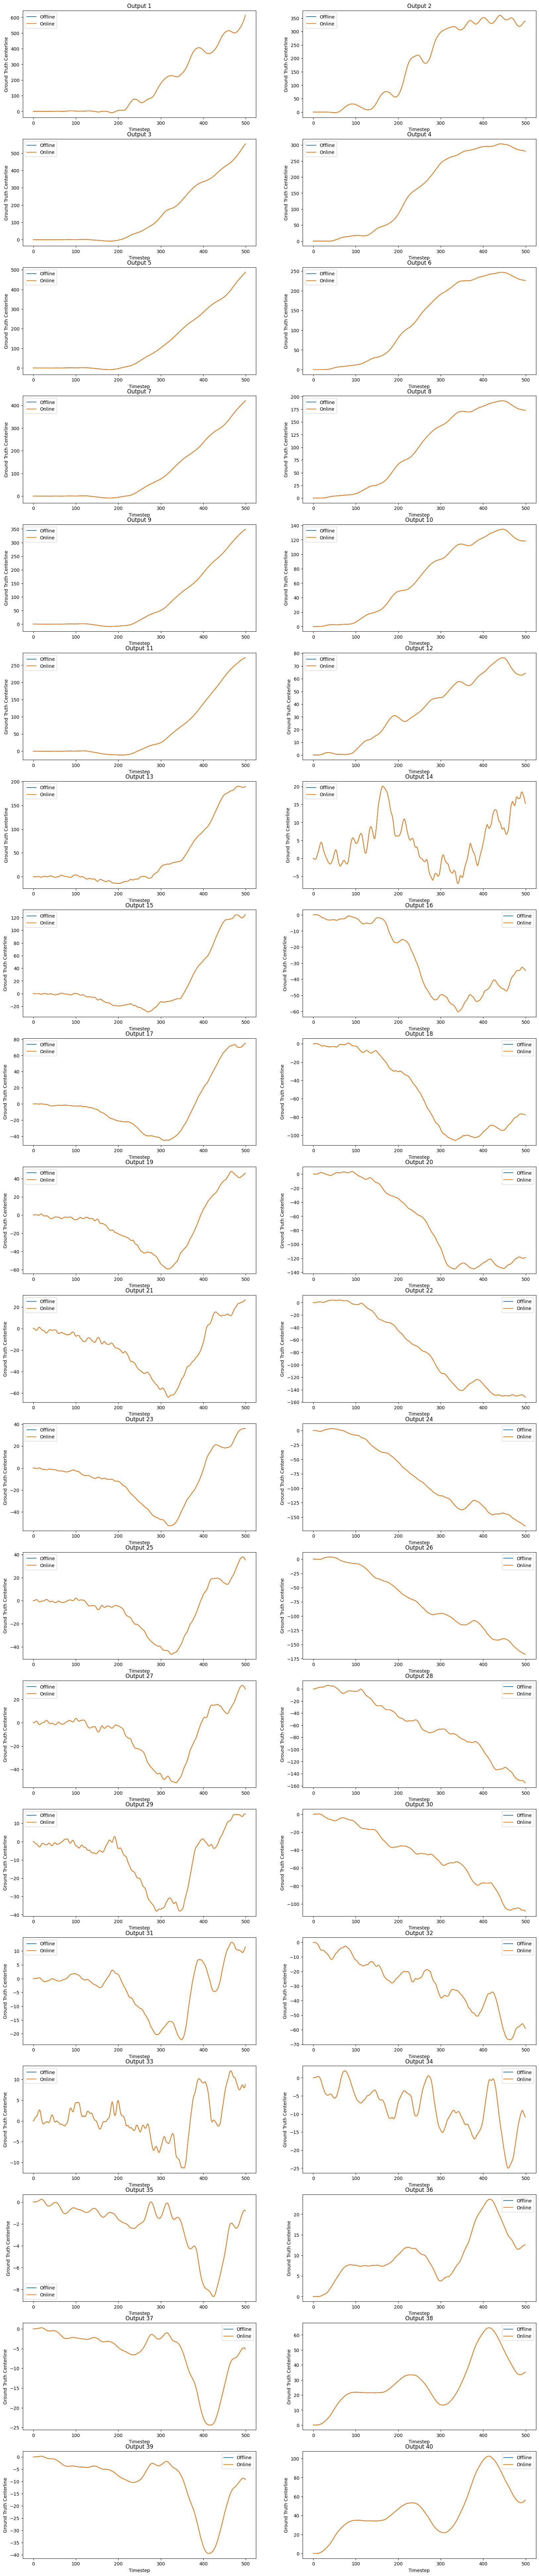

In [323]:
# Plot ground truths for each output as a subfigure for the online and offline centerlines
fig, ax = plt.subplots(C_era.shape[0]//2,2, figsize=(20,100))
# Iterate through each output plotting evens in the first column and odds in the second
for outputIndex in range(C_era.shape[0]):
    # Plot offline centerline
    ax[outputIndex//2,outputIndex%2].plot(Y_fom[outputIndex,:timesteps], label="Offline")
    # Plot online centerline
    ax[outputIndex//2,outputIndex%2].plot(y_groundTruth_online[outputIndex,:timesteps], label="Online")
    ax[outputIndex//2,outputIndex%2].legend()
    ax[outputIndex//2,outputIndex%2].set_title("Output " + str(outputIndex+1))
    ax[outputIndex//2,outputIndex%2].set_xlabel("Timestep")
    ax[outputIndex//2,outputIndex%2].set_ylabel("Ground Truth Centerline")

## Comparing State Estimation Online vs Offline

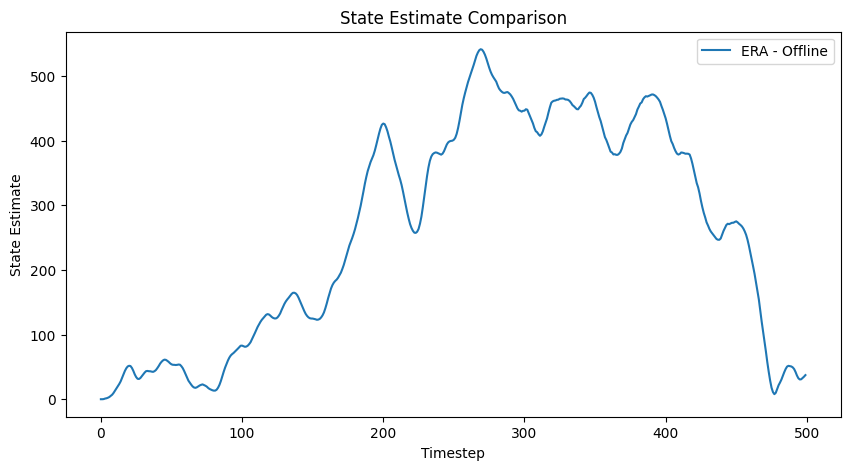

In [324]:
# Plot first state estimates from each observer
plt.figure(figsize=(10,5))
plt.plot(x_hat_era[0,:], label="ERA - Offline")
# plt.plot(x_hat_era_online[0,:], label="ERA - Online")
plt.legend()
plt.title("State Estimate Comparison")
plt.xlabel("Timestep")
plt.ylabel("State Estimate")
plt.show()

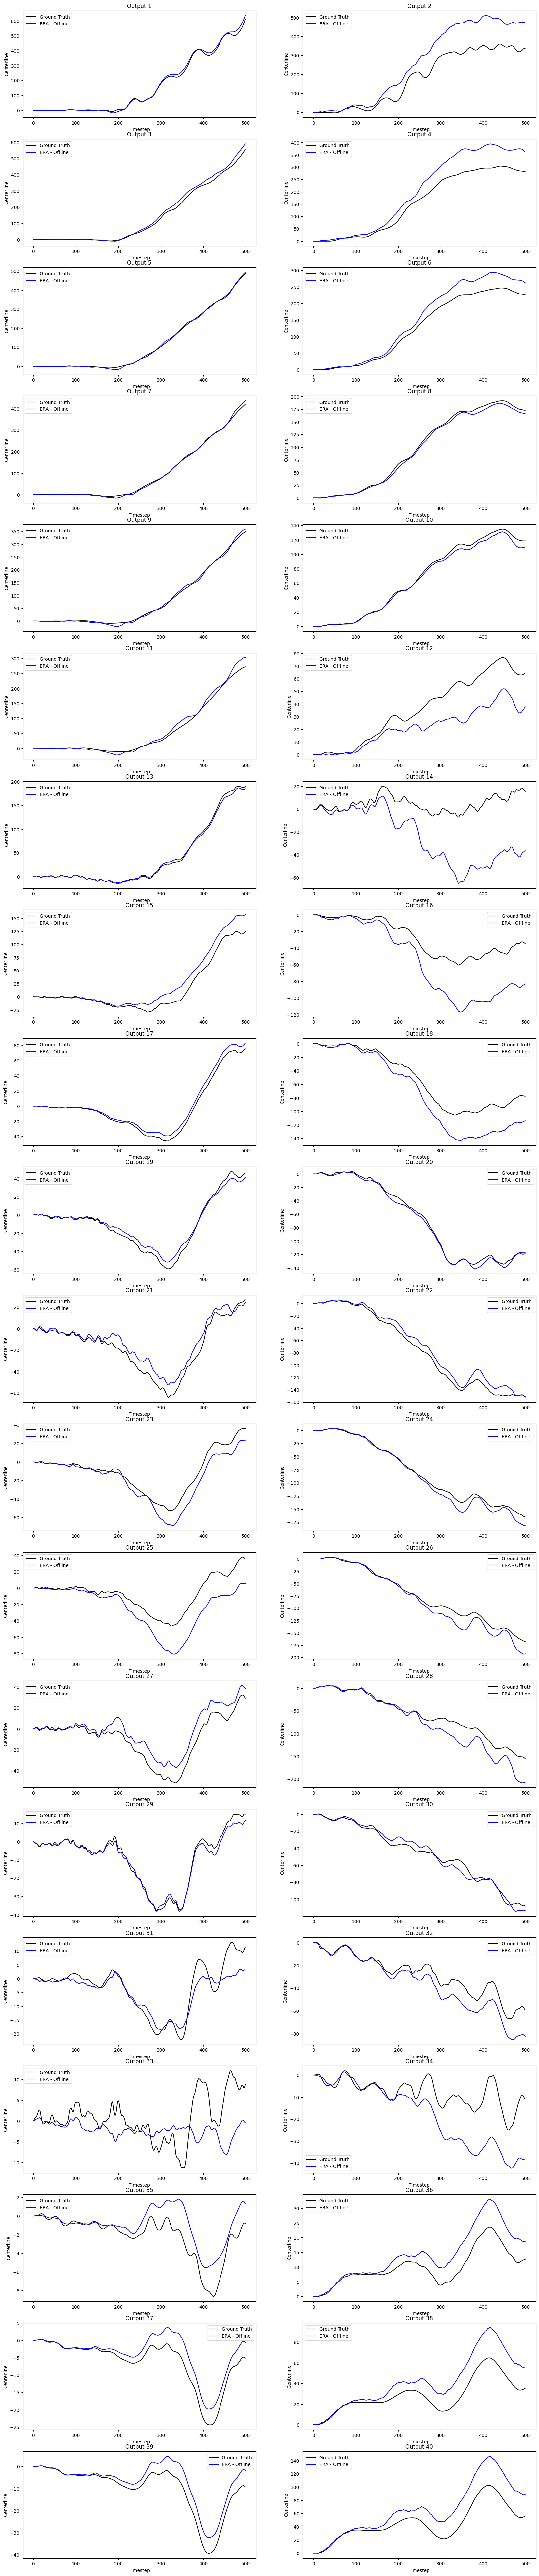

In [325]:
# Plot all outputs from online and offline estimators against ground truth
fig, ax = plt.subplots(C_era.shape[0]//2,2, figsize=(20,100))
# Iterate through each output plotting evens in the first column and odds in the second
for outputIndex in range(C_era.shape[0]):
    # Plot offline ground truth centerline
    ax[outputIndex//2,outputIndex%2].plot(Y_fom[outputIndex,:timesteps], label="Ground Truth", color="black")
    # Plot offline centerline estimate
    ax[outputIndex//2,outputIndex%2].plot(y_hat_era[outputIndex,:timesteps], label="ERA - Offline", color="blue")
    # Plot online centerline estimate
    # ax[outputIndex//2,outputIndex%2].plot(y_hat_era_online[outputIndex,:timesteps], label="ERA - Online", color = "red")
    ax[outputIndex//2,outputIndex%2].legend()
    ax[outputIndex//2,outputIndex%2].set_title("Output " + str(outputIndex+1))
    ax[outputIndex//2,outputIndex%2].set_xlabel("Timestep")
    ax[outputIndex//2,outputIndex%2].set_ylabel("Centerline")

Text(0, 0.5, 'Output')

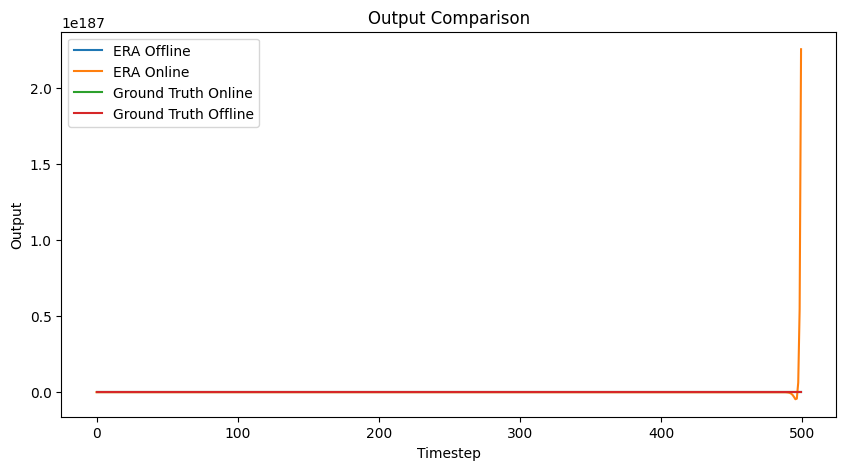

In [326]:
# Plot  groundtruths: Online values are solid lines offline values are dotted lines
outputIndex = 0
plt.figure(figsize=(10,5))
plt.plot(y_hat_era[outputIndex,:], label="ERA Offline")
plt.plot(y_hat_era_online[outputIndex,:], label="ERA Online")
plt.plot(y_groundTruth_online[outputIndex,:], label="Ground Truth Online")
plt.plot(Y_fom[outputIndex,:], label="Ground Truth Offline")
plt.legend()
plt.title("Output Comparison")
plt.xlabel("Timestep")
plt.ylabel("Output")


In [327]:
y_groundTruth_online[:,:timesteps].shape

(40, 500)

In [328]:
y_groundTruth_online[:,:timesteps].shape

(40, 500)

In [329]:
# Compute relative error of centerline outputs 
centerlineCompError_rel = np.linalg.norm(y_groundTruth_online[:,:timesteps] - Y_fom[:,:timesteps],ord='fro')/np.linalg.norm(Y_fom[:,:timesteps])*100
centerlineCompError_rel

6.217049084052578e-14

In [330]:
np.linalg.norm(y_hat_era_online)

inf